Задача: выделить пользователей максимально похожих на заданную целевую группу (look-alike).

In [1]:
# обработка
import numpy as np
import pandas as pd

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# моделирование
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# метрики
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, f1_score, classification_report

### 1. Подгрузка данных и определение объема исходной целевой группы.

In [2]:
# база данных панелистов

df_base = pd.read_csv('D:\\Work\\data\\lal_shop\\panelists_info_base.csv', sep=';')
df_base.head(10)

,media_login,gender,age,city_name,tv_count,hh_group,income
0,ssp1006581,Female,52,Moscow,1.0,HH with kids 0-17,15001-40000
1,ssp10201,Female,39,Moscow,1.0,HH with kids 0-17,15001-40000
2,ssp1021818,Female,65,Moscow,NaN,HH without kid 0-17,15000 and less
3,ssp103063,Female,33,Moscow,1.0,HH without kid 0-17,15000 and less
4,ssp1035990,Female,55,Moscow,2.0,HH with kids 0-17,15000 and less
5,ssp10477,Male,51,Moscow,NaN,HH with kids 0-17,15001-40000
6,ssp105912,Female,66,Moscow,0.0,HH with kids 0-17,15001-40000
7,ssp1061303,Female,40,Moscow,NaN,HH with kids 0-17,15001-40000
8,ssp1064073,Female,40,Moscow,1.0,HH without kid 0-17,15001-40000
9,ssp1067454,Female,58,Moscow,NaN,HH with kids 0-17,15001-40000


media_login - идентификатор (id респондента)   
gender - пол  
age - возраст  
city_name - город  
tv_count - количество ТВ  
hh_group - наличие детей в домохозяйстве  
income - доход

In [3]:
# объем базы - 7136 панелистов, 6 переменных

df_base.shape

(7136, 7)

In [4]:
# список id известной целевой

df_ids = pd.read_csv('D:\\Work\\data\\lal_shop\\target_ids.csv', sep=';')
df_ids.head(10)

,media_login
0,ssp134105
1,ssp1467104
2,ssp150010
3,ssp1577910
4,ssp1689107
5,ssp1762610
6,ssp1801410
7,ssp1807109
8,ssp1006581
9,ssp10201


In [5]:
# проставим 0 и 1 для групп

df_base['target'] = 0 # сначала 0 всем панелистам
df_ids_values = df_ids['media_login'].unique().tolist() # отбираем список id целевой группы
df_base['target'].loc[df_base['media_login'].isin(df_ids_values)] = 1 # проставляем 1 уже известной целевой группе
df_base

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,media_login,gender,age,city_name,tv_count,hh_group,income,target
0,ssp1006581,Female,52,Moscow,1.0,HH with kids 0-17,15001-40000,1
1,ssp10201,Female,39,Moscow,1.0,HH with kids 0-17,15001-40000,1
2,ssp1021818,Female,65,Moscow,NaN,HH without kid 0-17,15000 and less,1
3,ssp103063,Female,33,Moscow,1.0,HH without kid 0-17,15000 and less,1
4,ssp1035990,Female,55,Moscow,2.0,HH with kids 0-17,15000 and less,1
...,...,...,...,...,...,...,...,...
7131,ssp972463,Female,41,Moscow,1.0,HH with kids 0-17,15001-40000,0
7132,ssp974784,Male,64,Moscow,NaN,HH without kid 0-17,15000 and less,0
7133,ssp976214,Male,37,Moscow,1.0,HH with kids 0-17,15001-40000,0
7134,ssp986,Female,40,Moscow,NaN,HH with kids 0-17,40001+,0


In [6]:
# количество всех панелистов и известной целевой группы (в единицах)

df_base.groupby(['target'])['media_login'].count()

target
0    6752
1     384
Name: media_login, dtype: int64

In [7]:
# процент известной целевой группы среди всех панелистов (в процентах)

round(df_base['media_login'].isin(df_ids_values).sum() / df_base['media_login'].count(), 2)

0.05

Итого в изначальной целевой группе **5%** от всех. Данные предоставили только по Москве, поэтому удалим столбец с городом:

In [8]:
del df_base['city_name']

### 2. Посмотрим/почистим/подготовим данные для работы.

In [9]:
df_base.set_index('media_login', inplace=True)
df_base

,gender,age,tv_count,hh_group,income,target
media_login,,,,,,
ssp1006581,Female,52,1.0,HH with kids 0-17,15001-40000,1
ssp10201,Female,39,1.0,HH with kids 0-17,15001-40000,1
ssp1021818,Female,65,NaN,HH without kid 0-17,15000 and less,1
ssp103063,Female,33,1.0,HH without kid 0-17,15000 and less,1
ssp1035990,Female,55,2.0,HH with kids 0-17,15000 and less,1
...,...,...,...,...,...,...
ssp972463,Female,41,1.0,HH with kids 0-17,15001-40000,0
ssp974784,Male,64,NaN,HH without kid 0-17,15000 and less,0
ssp976214,Male,37,1.0,HH with kids 0-17,15001-40000,0


In [10]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7136 entries, ssp1006581 to ssp990108
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    7136 non-null   object 
 1   age       7136 non-null   int64  
 2   tv_count  2708 non-null   float64
 3   hh_group  7136 non-null   object 
 4   income    7136 non-null   object 
 5   target    7136 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 390.2+ KB


Есть пропущенные значения в tv_count, заменим с помощью стратифицированного среднего.

In [11]:
df_base['tv_count'].mean() # среднее кол-во ТВ 

1.637370753323486

In [12]:
df_base_tv = df_base[df_base['tv_count'].isna()].index # панелисты с неизвестным кол-вом ТВ
df_base['tv_count'].loc[df_base['tv_count'].index.isin(df_base_tv)] = 2 # заменим неизвестное на среднее - 2 (округленное 1.63)
df_base

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,gender,age,tv_count,hh_group,income,target
media_login,,,,,,
ssp1006581,Female,52,1.0,HH with kids 0-17,15001-40000,1
ssp10201,Female,39,1.0,HH with kids 0-17,15001-40000,1
ssp1021818,Female,65,2.0,HH without kid 0-17,15000 and less,1
ssp103063,Female,33,1.0,HH without kid 0-17,15000 and less,1
ssp1035990,Female,55,2.0,HH with kids 0-17,15000 and less,1
...,...,...,...,...,...,...
ssp972463,Female,41,1.0,HH with kids 0-17,15001-40000,0
ssp974784,Male,64,2.0,HH without kid 0-17,15000 and less,0
ssp976214,Male,37,1.0,HH with kids 0-17,15001-40000,0


In [13]:
# посмотрим, какие уникальные значения есть для каждой из переменных

uniq_values = {}
for uniq in df_base.columns:
    uniq_values[uniq] = df_base[uniq].unique().tolist()
    print (uniq, ': ', df_base[uniq].unique().tolist())

gender :  ['Female', 'Male']
age :  [52, 39, 65, 33, 55, 51, 66, 40, 58, 31, 32, 56, 45, 46, 57, 60, 19, 18, 61, 38, 64, 35, 67, 63, 88, 49, 36, 30, 37, 44, 15, 34, 25, 20, 59, 50, 47, 48, 74, 53, 29, 27, 22, 41, 43, 62, 17, 42, 78, 24, 16, 23, 76, 87, 54, 73, 21, 72, 28, 80, 26, 68, 79, 69, 81, 70, 71, 84, 83, 14, 82, 86, 85, 77, 102]
tv_count :  [1.0, 2.0, 0.0, 3.0, 4.0, 5.0, 6.0]
hh_group :  ['HH with kids 0-17', 'HH without kid 0-17']
income :  ['15001-40000', '15000 and less', '40001+']
target :  [1, 0]


Очевидно, возраст стоит перевести в интервалы (в виду небольшого общего количества наблюдений) и затем закодировать. Тогда как категориальные переменные пол, количество ТВ, наличие детей и доход перекодируем как есть.

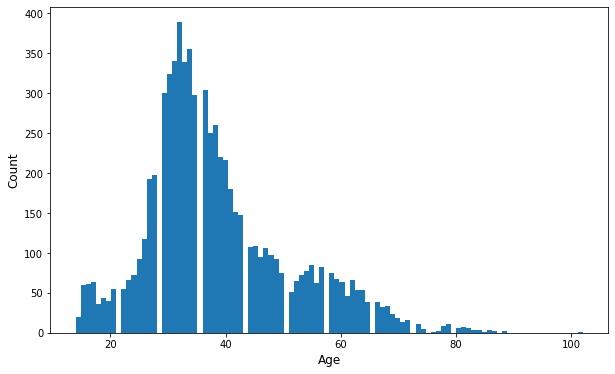

In [14]:
# возраст

plt.figure(figsize=(10, 6))
plt.hist(df_base['age'], bins = 100)
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

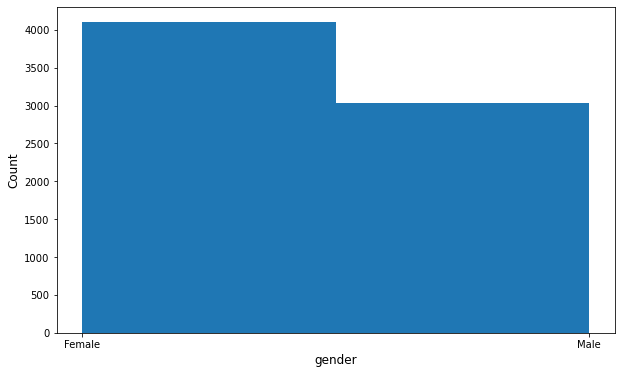

In [15]:
# пол

plt.figure(figsize=(10, 6))
plt.hist(df_base['gender'], bins = 2)
plt.xlabel('gender', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

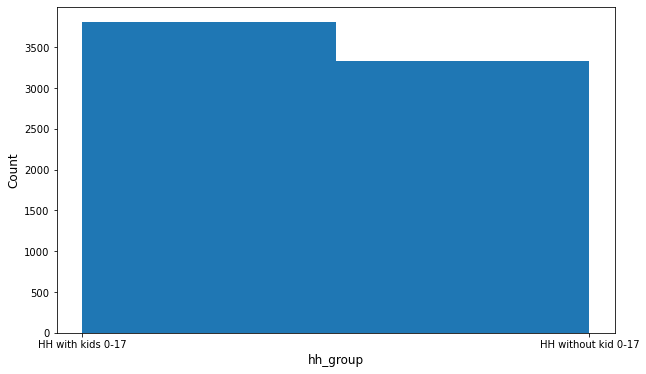

In [16]:
# hh_group

plt.figure(figsize=(10, 6))
plt.hist(df_base['hh_group'], bins = 2)
plt.xlabel('hh_group', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

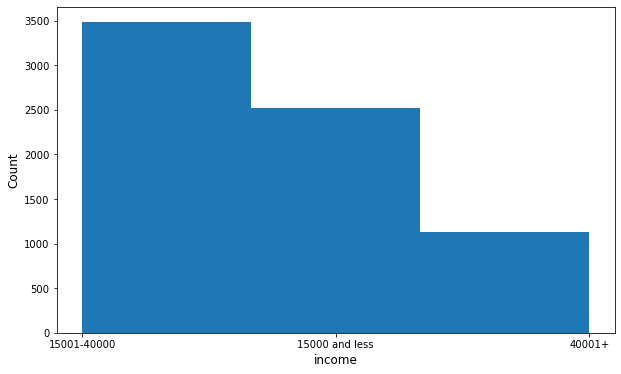

In [17]:
# доход

plt.figure(figsize=(10, 6))
plt.hist(df_base['income'], bins = 3)
plt.xlabel('income', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

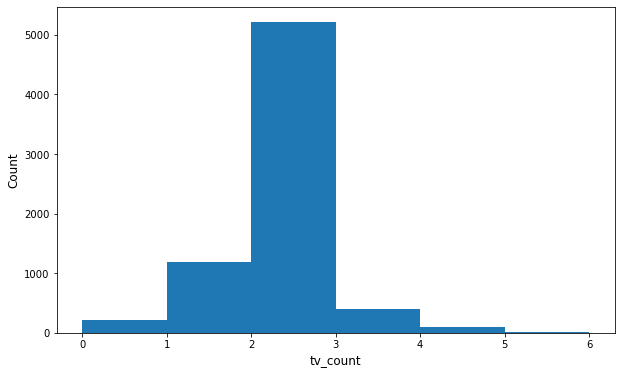

In [18]:
# количество ТВ

plt.figure(figsize=(10, 6))
plt.hist(df_base['tv_count'], bins = 6)
plt.xlabel('tv_count', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

In [19]:
df_base

,gender,age,tv_count,hh_group,income,target
media_login,,,,,,
ssp1006581,Female,52,1.0,HH with kids 0-17,15001-40000,1
ssp10201,Female,39,1.0,HH with kids 0-17,15001-40000,1
ssp1021818,Female,65,2.0,HH without kid 0-17,15000 and less,1
ssp103063,Female,33,1.0,HH without kid 0-17,15000 and less,1
ssp1035990,Female,55,2.0,HH with kids 0-17,15000 and less,1
...,...,...,...,...,...,...
ssp972463,Female,41,1.0,HH with kids 0-17,15001-40000,0
ssp974784,Male,64,2.0,HH without kid 0-17,15000 and less,0
ssp976214,Male,37,1.0,HH with kids 0-17,15001-40000,0


### 3. Выделим look-alike панелистов

In [20]:
# сделаем дамми переменные

df_base_gd = pd.get_dummies(df_base, columns = ['gender', 'tv_count', 'hh_group', 'income'] , prefix_sep = "_", drop_first = True)
del df_base_gd['age']

df_base_gd

,target,gender_Male,tv_count_1.0,tv_count_2.0,tv_count_3.0,tv_count_4.0,tv_count_5.0,tv_count_6.0,hh_group_HH without kid 0-17,income_15001-40000,income_40001+
media_login,,,,,,,,,,,
ssp1006581,1,0,1,0,0,0,0,0,0,1,0
ssp10201,1,0,1,0,0,0,0,0,0,1,0
ssp1021818,1,0,0,1,0,0,0,0,1,0,0
ssp103063,1,0,1,0,0,0,0,0,1,0,0
ssp1035990,1,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
ssp972463,0,0,1,0,0,0,0,0,0,1,0
ssp974784,0,1,0,1,0,0,0,0,1,0,0
ssp976214,0,1,1,0,0,0,0,0,0,1,0


In [21]:
# добавим псведопеременную для целевой

pos_ind = np.where(df_base_gd['target'].values == 1)[0]
np.random.shuffle(pos_ind)
pos_sample_len = int(np.ceil(0.33 * len(pos_ind))) # оставим 33% от известной целевой группы
print(f'Используем {pos_sample_len} / {len(pos_ind)} панелистов из целевой группы и неразмеченных.')
pos_sample = pos_ind[:pos_sample_len]

Используем 127 / 384 панелистов из целевой группы и неразмеченных.


In [22]:
# проставим -1 для неразмеченных и 1 для целевой в целевой (всё в рамках изначальной размеченной целевой группы)

df_base_gd['pseudo'] = -1
df_base_gd.iloc[pos_sample, -1] = 1
print('Целевая группа:\n', df_base_gd.iloc[:, -1].value_counts())

Целевая группа:
 -1    7009
 1     127
Name: pseudo, dtype: int64


In [23]:
df_base_gd

,target,gender_Male,tv_count_1.0,tv_count_2.0,tv_count_3.0,tv_count_4.0,tv_count_5.0,tv_count_6.0,hh_group_HH without kid 0-17,income_15001-40000,income_40001+,pseudo
media_login,,,,,,,,,,,,
ssp1006581,1,0,1,0,0,0,0,0,0,1,0,-1
ssp10201,1,0,1,0,0,0,0,0,0,1,0,-1
ssp1021818,1,0,0,1,0,0,0,0,1,0,0,-1
ssp103063,1,0,1,0,0,0,0,0,1,0,0,-1
ssp1035990,1,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
ssp972463,0,0,1,0,0,0,0,0,0,1,0,-1
ssp974784,0,1,0,1,0,0,0,0,1,0,0,-1
ssp976214,0,1,1,0,0,0,0,0,0,1,0,-1


Будем использовать метод Positive-Unlables Classification на основе LogisticRegression

In [24]:
X = df_base_gd.iloc[:, 1:-1].values # все переменные без target и pseudo
Y = df_base_gd.iloc[:, -1].values # позитивные и неразмеченные внутри исходной целевой (pseudo)
y = df_base_gd.iloc[:, 0].values # исходная целевая группа (target)

In [25]:
def fit_PU_estimator(X, y, hold_out_ratio, estimator):
    # Обучающий набор будет разделен на примерочный набор, который будет использоваться.
    # чтобы соответствовать оценщику для оценки P (s = 1 | X) и заданного набора положительных выборок
    # который будет использоваться для оценки P (s = 1 | y = 1)
    # найти индексы положительных / помеченных элементов
    assert (type(y) == np.ndarray), "Must pass np.ndarray rather than list as y"
    positives = np.where(y == 1.)[0] 
    # hold_out_size = количество положительных результатов / помеченых элементов
    # это используем для оценки P (s = 1 | y = 1)
    hold_out_size = int(np.ceil(len(positives) * hold_out_ratio))
    np.random.shuffle(positives)
    # hold_out = индексы положительных элементов
    # это используем для оценки P (s = 1 | y = 1)
    hold_out = positives[:hold_out_size] 
    # фактические положительные элементы, которые мы оставим в стороне
    X_hold_out = X[hold_out] 
    # удалить отобранные элементы из X и y
    X = np.delete(X, hold_out, 0) 
    y = np.delete(y, hold_out)
    # подбираем оценщик непомеченных элементов + (часть) положительных и помеченых. 
    # чтобы оценить P (s = 1 | X) или какова вероятность того, что элемент помечен
    estimator.fit(X, y)
    # затем мы используем оценщик для предсказания look-alike множества элементов
    # для оценки P (s = 1 | y = 1)
    hold_out_predictions = estimator.predict_proba(X_hold_out)
    # допустим вероятность, что это 1
    hold_out_predictions = hold_out_predictions[:, 1]
    # сохраним среднюю вероятность
    c = np.mean(hold_out_predictions)
    return estimator, c

def predict_PU_prob(X, estimator, prob_s1y1):
    # предскажем вероятность
    prob_pred = estimator.predict_proba(X)
    prob_pred = prob_pred[:, 1]
    return prob_pred / prob_s1y1

In [26]:
pu_estimator, probs1y1 = fit_PU_estimator(
  X,
  Y,
  0.2,
  LogisticRegression())

predicted_s = pu_estimator.predict_proba(X)
predicted_s = predicted_s[:, 1]
predicted_y = predicted_s / probs1y1

In [27]:
predicted = np.zeros(len(X))
learning_iterations = 25
for index in range(learning_iterations):
    pu_estimator, probs1y1 = fit_PU_estimator(X, Y, 0.2, LogisticRegression())
    predicted += predict_PU_prob(X, pu_estimator, probs1y1)
    if(index%4 == 0): 
        print(f'Learning Iteration::{index}/{learning_iterations} => P(s=1|y=1)={round(probs1y1, 2)}')

Learning Iteration::0/25 => P(s=1|y=1)=0.01
Learning Iteration::4/25 => P(s=1|y=1)=0.01
Learning Iteration::8/25 => P(s=1|y=1)=0.02
Learning Iteration::12/25 => P(s=1|y=1)=0.01
Learning Iteration::16/25 => P(s=1|y=1)=0.01
Learning Iteration::20/25 => P(s=1|y=1)=0.01
Learning Iteration::24/25 => P(s=1|y=1)=0.02


In [28]:
y_predict = [1 if x > 0.5 else 0 for x in (predicted/learning_iterations)]

In [29]:
def evaluate_results(y, y_predict):
    print('Classification results:')
    f1 = f1_score(y, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

    
evaluate_results(y, y_predict)

Classification results:
f1: 96.21%
roc: 97.14% 
recall: 98.41% 
precision: 97.38%
